#### Text Loading
- Utils and Preprocessing: `tf.keras.utils.text_dataset_from_directory`, `tf.data.Dataset`, `tf.keras.layers.TextVectorization`
- Lower Level Utils: `tf.data.TextLineDataset`, `tf.lookup`
- TensorFlow Text APIs: `text.UnicodeScriptTokenizer`, `text.case_fold_utf8`

In [1]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, losses, utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import tqdm as notebokk_tqdm

2024-01-11 20:43:54.380666: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 20:43:54.409587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 20:43:54.409614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 20:43:54.410311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 20:43:54.415064: I tensorflow/core/platform/cpu_feature_guar

#### Predicting the tag for a Stack Overflow Question
- Simple tools: `keras.utils.text_dataset_from_directory`, `keras.layers.TextVectorization`, `tf.keras.utils.get_file`

Get Data

In [2]:
data_url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir = 'so_16k/',
    cache_subdir=''
)

dataset_dir = pathlib.Path(dataset_dir).parent

In [3]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/train'),
 PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/README.md')]

In [4]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/python'),
 PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/java')]

In [5]:
sample_file = train_dir/'python/1755.txt'

with open(sample_file) as f:
    print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



Load Data

In [6]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2024-01-11 20:43:58.283716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 20:43:58.306843: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 20:43:58.306883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 20:43:58.309633: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 20:43:58.309681: I external/local_xla/xla/stream_executor

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print("Question: ", text_batch.numpy()[i])
        print("Label: ", label_batch.numpy()[i])

Question:  b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public stati

In [9]:
for i, label in enumerate(raw_train_ds.class_names):
    print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [10]:
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [11]:
test_dir = dataset_dir/'test'

# Create test set
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [12]:
# Configure dataset for performance

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary' # Bag of words model, AKA word order does not matter
)

In [14]:
MAX_SEQ_LEN = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int', # 1D ConvNet model, word order matters
    output_sequence_length=MAX_SEQ_LEN
)

In [16]:
# Make a text_only dataset (without labels) and adapt TextVectorization layer
train_text = raw_train_ds.map(lambda text, labels:text) # Get only text data
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [17]:
# Retreive a batch from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
q1, l1 = text_batch[0], label_batch[0]
print("Q: ", q1)
print("L: ", l1)

Q:  tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extra b

binary vectorized question [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.

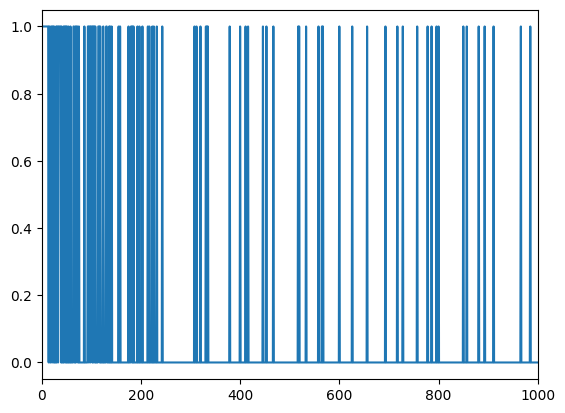

In [18]:
# We end up with a multi-hot vector showing which tokens exist at least once in the input
print("binary vectorized question", list(binary_vectorize_layer(q1).numpy()))

plt.plot(binary_vectorize_layer(q1).numpy())
plt.xlim(0,1000);

In [19]:
# Int mode replaces each token with an integer, thus preserving order
print("int vectorized question:", int_vectorize_layer(q1).numpy())

int vectorized question: [ 107   16    4 1139   37  184   52   47   16    1  215  417  518   12
   32  182    4   13   26    3 1416  227   11  894  627   52  309  718
   16 1274  100    5  244 1826    8  119  224   95   97  657  858    1
  797   20  125  117  559 2282  194   73    9   23   30   50    3  115
  566   10   97   59   73  204    4  412   16    4 1139   45 1670  601
    5  694   38    4   14  851   37  967   97   98   65 2374    9  132
   45   55   11  227  401    2  244 1826   72  534  156  967    8 7808
   32   65  468   11  181 2332  198 1461    4    1 1093  447  309  100
   71   65  454  109    5 3560  224   20  139   36   11 9052   37  233
   14    2    1  224  107   12  137   76  779    3  102   14    3  176
 1853    2  332    4    5   39    4  787   12 1320 3579   26  106    1
    2   98   65    8 2902    2  244    1   69   33  336    1    5 1759
    9 1157 2531    9  568  729   12    1    4  321   13    2 1826   52
   47    2    1  244 1826    6 2619    7  131   50  

`TextVectorization.get_vocabulary` to do a token lookup

In [20]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source
Vocabulary size: 10000


TRAIN THE MODEL

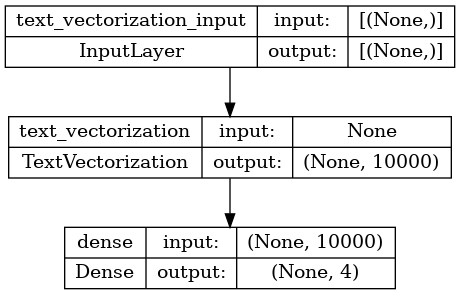

In [21]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)
])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

tf.keras.utils.plot_model(binary_model, show_shapes=True)

In [22]:
bin_history = binary_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10
  1/200 [..............................] - ETA: 1:33 - loss: 1.4136 - accuracy: 0.2188

2024-01-11 21:49:51.657954: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4a17c49300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-11 21:49:51.657990: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-01-11 21:49:51.662638: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-11 21:49:51.675466: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1705038591.737308  128325 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 2s 9ms/step - loss: 1.1186 - accuracy: 0.6456 - val_loss: 0.9134 - val_accuracy: 0.7756
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7791 - accuracy: 0.8186 - val_loss: 0.7496 - val_accuracy: 0.8012
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6278 - accuracy: 0.8625 - val_loss: 0.6640 - val_accuracy: 0.8131
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5343 - accuracy: 0.8880 - val_loss: 0.6106 - val_accuracy: 0.8213
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4682 - accuracy: 0.9067 - val_loss: 0.5740 - val_accuracy: 0.8319
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4179 - accuracy: 0.9186 - val_loss: 0.5474 - val_accuracy: 0.8363
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3776 - accuracy: 0.9302 - val_loss: 0.5274 - val_accuracy: 0.8394
Epoch 8/10
200/20

In [23]:
# Int model

def create_model(vocab_size, num_labels, vectorizer=None):
    my_layers = []
    if vectorizer is not None:
        my_layers = [vectorizer]
    
    my_layers.extend([
        layers.Embedding(vocab_size, 64, mask_zero=True),
        layers.Dropout(0.5),
        layers.Conv1D(64, 5, padding="valid", activation='relu', strides=2),
        layers.GlobalMaxPooling1D(),
        layers.Dense(num_labels)
    ])

    model = tf.keras.Sequential(my_layers)
    return model

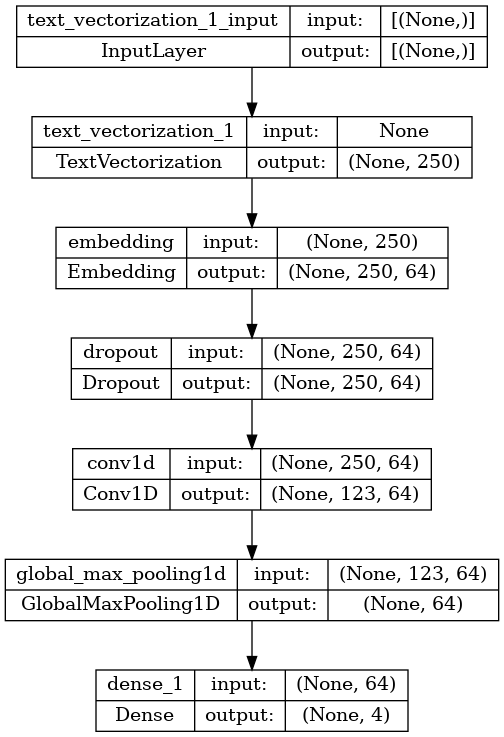

In [24]:
# vocab_size = VOCAB_SIZE + 1 since 0 is used additionally for padding
int_model = create_model(VOCAB_SIZE+1, num_labels=4, vectorizer=int_vectorize_layer)
tf.keras.utils.plot_model(int_model, show_shapes=True)

In [25]:
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)
int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10


2024-01-11 21:57:05.644953: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


200/200 [==============================] - 18s 78ms/step - loss: 1.2564 - accuracy: 0.4198 - val_loss: 0.9542 - val_accuracy: 0.5850
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.7907 - accuracy: 0.6712 - val_loss: 0.6548 - val_accuracy: 0.7275
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.5795 - accuracy: 0.7781 - val_loss: 0.5650 - val_accuracy: 0.7837
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4289 - accuracy: 0.8589 - val_loss: 0.5105 - val_accuracy: 0.8087
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3040 - accuracy: 0.9048 - val_loss: 0.4959 - val_accuracy: 0.8100
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2193 - accuracy: 0.9367 - val_loss: 0.5051 - val_accuracy: 0.8150
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1560 - accuracy: 0.9580 - val_loss: 0.5330 - val_accuracy: 0.8150
Epoch 8/10
200/

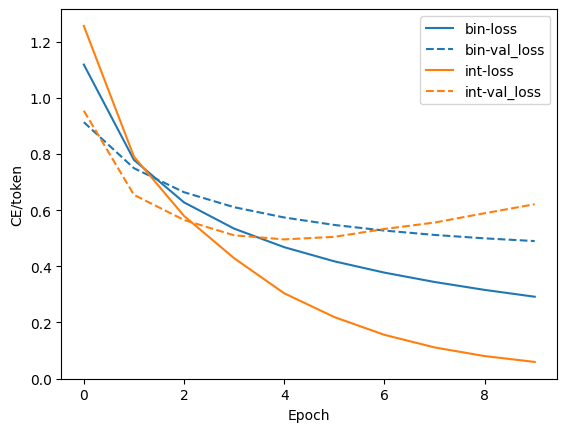

In [27]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token');

Model Exporting

Apply `TextVectorization` to the training, validation, and test sets. This will allow the model to be exported so it can do predictions. During training, you probably don't want to include preporcessing layers in your model since you can do the preprocessing more effeciently outside of it/

In [29]:
binary_train_ds = raw_train_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_val_ds = raw_val_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_test_ds = raw_test_ds.map(lambda x,y: (binary_vectorize_layer(x), y))

int_train_ds = raw_train_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_val_ds = raw_val_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_test_ds = raw_test_ds.map(lambda x,y: (int_vectorize_layer(x), y))

In [30]:
binary_model.export('../saved_models/bin_text_basics.tf')

INFO:tensorflow:Assets written to: ../saved_models/bin_text_basics.tf/assets


INFO:tensorflow:Assets written to: ../saved_models/bin_text_basics.tf/assets


Saved artifact at '../saved_models/bin_text_basics.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='text_vectorization_input')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139959300489056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139959301310768: TensorSpec(shape=(), dtype=tf.int64, name=None)
  139959301814224: TensorSpec(shape=(), dtype=tf.string, name=None)
  139959301814048: TensorSpec(shape=(), dtype=tf.int64, name=None)
  139962507919200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139959294699120: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [31]:
loaded = tf.saved_model.load('../saved_models/bin_text_basics.tf')
binary_model.predict(['How do I sort a list?'])

1/1 [==============================] - 0s 96ms/step


array([[-0.0236378 , -0.03155514, -0.7263333 ,  0.3984913 ]],
      dtype=float32)

In [33]:
loaded.serve(tf.constant(['How do I sort a list?'])).numpy()

array([[-0.0236378 , -0.03155514, -0.7263333 ,  0.3984913 ]],
      dtype=float32)

#### Predict the author of Iliad Translations
- `tf.data.TextLineDataset`: Load examples from text files and Tensorflow Text to process data
- Make bespoke `TextVectorization`: Use `text.UnicodeScriptTokenizer` and `tf.lookup.StaticVocabularyTable`

In [34]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
    text_dir = utils.get_file(name, origin=DIRECTORY_URL+name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

807992/807992 [==============================] - 0s 0us/step


[PosixPath('/home/kmirijan/.keras/datasets/train.csv'),
 PosixPath('/home/kmirijan/.keras/datasets/fashion-mnist'),
 PosixPath('/home/kmirijan/.keras/datasets/HIGGS.csv.gz'),
 PosixPath('/home/kmirijan/.keras/datasets/derby.txt'),
 PosixPath('/home/kmirijan/.keras/datasets/cowper.txt'),
 PosixPath('/home/kmirijan/.keras/datasets/mnist.npz'),
 PosixPath('/home/kmirijan/.keras/datasets/heart.csv'),
 PosixPath('/home/kmirijan/.keras/datasets/flower_photos.tgz'),
 PosixPath('/home/kmirijan/.keras/datasets/butler.txt'),
 PosixPath('/home/kmirijan/.keras/datasets/flower_photos')]

Use `TextLineDataset` to load line by line text data. Iterate through the files and with `Dataset.map` apply a labeler

In [35]:
# Labeler
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

labeled_datasets = []
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(str(parent_dir/file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_datasets.append(labeled_dataset)

In [36]:
# Combine the datasets and shuffle
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [39]:
all_labeled_data = labeled_datasets[0]
for labeled_dataset in labeled_datasets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)

In [40]:
for text, label in all_labeled_data.take(10):
    print("Sentence: ", text.numpy())
    print("Label: ", label.numpy())

Sentence:  b'The ruthless point, and, falling, he expired.'
Label:  0
Sentence:  b'fight me? Is it that you hope to reign over the Trojans in the seat of'
Label:  2
Sentence:  b'Of Paris, who when to his rural hut'
Label:  0
Sentence:  b'Blood-tinctured dews among them, for he meant'
Label:  0
Sentence:  b'Minerva had endowed him with great strength. Nevertheless Scamander did'
Label:  2
Sentence:  b'ships and the river Xanthus. A thousand camp-fires gleamed upon the'
Label:  2
Sentence:  b'And laid before his feet; intent to slay,'
Label:  1
Sentence:  b'foretell my death? You need not do so, for I well know that I am to'
Label:  2
Sentence:  b'Our foes he equals, and our strength confounds.'
Label:  1
Sentence:  b'trick which Apollo had played the son of Tydeus, so she brought him his'
Label:  2


Dataset Preparation

- `tf.lookup.StaticVocabularyTable`, `text.UnicodeScriptTokenizer`
- `RaggedTensor` is a tensor with variable length records

In [41]:
class MyTokenizer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.tokenizer = tf_text.UnicodeScriptTokenizer()
    
    def call(self, text):
        lower_case = tf_text.case_fold_utf8(text) # This just makes everything lowercase
        result = self.tokenizer.tokenize(lower_case)
        # If a batch of strings is passed, a RaggedTensor will be returned
        if isinstance(result, tf.RaggedTensor):
            result = result.to_tensor()
        return result

tokenizer = MyTokenizer()

In [42]:
tokenized_ds = all_labeled_data.map(lambda text, label: (tokenizer(text), label))
tokenized_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [49]:
# Let's take a look
for tokens, label in tokenized_ds.take(5):
    print(tokens, '\n\n', label, '\n')

tf.Tensor(
[b'the' b'ruthless' b'point' b',' b'and' b',' b'falling' b',' b'he'
 b'expired' b'.'], shape=(11,), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64) 

tf.Tensor(
[b'fight' b'me' b'?' b'is' b'it' b'that' b'you' b'hope' b'to' b'reign'
 b'over' b'the' b'trojans' b'in' b'the' b'seat' b'of'], shape=(17,), dtype=string) 

 tf.Tensor(2, shape=(), dtype=int64) 

tf.Tensor([b'of' b'paris' b',' b'who' b'when' b'to' b'his' b'rural' b'hut'], shape=(9,), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64) 

tf.Tensor(
[b'blood' b'-' b'tinctured' b'dews' b'among' b'them' b',' b'for' b'he'
 b'meant'], shape=(10,), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64) 

tf.Tensor(
[b'minerva' b'had' b'endowed' b'him' b'with' b'great' b'strength' b'.'
 b'nevertheless' b'scamander' b'did'], shape=(11,), dtype=string) 

 tf.Tensor(2, shape=(), dtype=int64) 



In [52]:
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

vocab_count = collections.Counter()
for toks, labels in tokenized_ds.ragged_batch(1000): # Create batches of data with variable length sequences
    toks = tf.reshape(toks, [-1])
    for tok in toks.numpy():
        vocab_count[tok] += 1 # Count of each token

    vocab = [tok for tok, count in vocab_count.most_common(VOCAB_SIZE)] # Select the top VOCAB_SIZE (in this case 10000) tokens by count

# Kind of annoying that a comma is the top word. Shouldn't we be taking out stopwords and punctuation???
print("First 5", vocab[:5])

First 5 [b',', b'the', b'and', b"'", b'of']


Convert Tokens to Integers

`tf.lookup.KeyValueTensorInitializer`, `tf.lookup.StaticVocabularyTable`

In [56]:
class MyVocabTable(tf.keras.layers.Layer):
    def __init__(self, vocab):
        super().__init__()
        self.keys = [''] + vocab # Add a '' to the vocab list
        self.values = range(len(self.keys)) # Make my integer lookup values 0 -len(vocab)

        self.init = tf.lookup.KeyValueTensorInitializer(
            self.keys, self.values, key_dtype=tf.string, value_dtype=tf.int64 # Create the Key Value tensor between vocab and lookup
        )

        num_oov_buckets = 1

        self.table = tf.lookup.StaticVocabularyTable(self.init, num_oov_buckets) # Assign out of vocab keys to hash buckets
    
    def call(self, x):
        result = self.table.lookup(x)
        return result

In [57]:
# Test vocab table
vocab_table = MyVocabTable(['a', 'b', 'c'])
vocab_table(tf.constant([''] + list('abcdefghi')))

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 2, 3, 4, 4, 4, 4, 4, 4])>

In [58]:
# Real vocab table
vocab_table = MyVocabTable(vocab)

In [59]:
# Text standardization, tokenization, and vectorization layer for the dataset
preprocess_text = tf.keras.Sequential([
    tokenizer,
    vocab_table
])

In [61]:
# Simple single example
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text = preprocess_text(example_text)
print('Vectorized: ', vectorized_text.numpy())

Sentence:  b'The ruthless point, and, falling, he expired.'
Vectorized:  [   2 1676  445    1    3    1 1768    1   11 3285    6]


Dataset Pipeline for preprocessing

In [68]:
all_encoded_data = all_labeled_data.map(lambda text, labels: (preprocess_text(text), labels))
for ids, label in all_encoded_data.take(10):
    print("IDs: ", ids.numpy())
    print('Label: ', label.numpy())

IDs:  [   2 1676  445    1    3    1 1768    1   11 3285    6]
Label:  0
IDs:  [  82   39   73   45   34   22   36  519    7 1330  190    2   61   12
    2  526    5]
Label:  2
IDs:  [   5  426    1   40   43    7   10 7805 9790]
Label:  0
IDs:  [ 205   16 9791 6425  166   38    1   18   11 4109]
Label:  0
IDs:  [ 292   42 3496   15   13  123  302    6 1195 1032  117]
Label:  2
IDs:  [  67    3    2  408  764    6   14 1511  440   16  926 3767   93    2]
Label:  2
IDs:  [   3  338  120   10  303    9 1163    7  542    1]
Label:  1
IDs:  [5027   31  133   73   36  707   30  185   37    1   18   20  115  262
   22   20  295    7]
Label:  2
IDs:  [  79  817   11 7806    1    3   79  302 5604    6]
Label:  1
IDs:  [5605   72  212   42 4110    2   27    5  332    1   37   68  294   15
   10]
Label:  2


Split data for training and testing

In [69]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE).padded_batch(BATCH_SIZE)

In [70]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (64, 19)
Label batch shape:  (64,)
First text example:  tf.Tensor(
[   2 1676  445    1    3    1 1768    1   11 3285    6    0    0    0
    0    0    0    0    0], shape=(19,), dtype=int64)
First label example:  tf.Tensor(0, shape=(), dtype=int64)


Train Model

In [71]:
# Performance
train_data = train_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [72]:
# Using the sequence model from Example 1
model = create_model(vocab_size=VOCAB_SIZE+2, num_labels=3) # + 2 for the 0 value and the oov bucket
model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

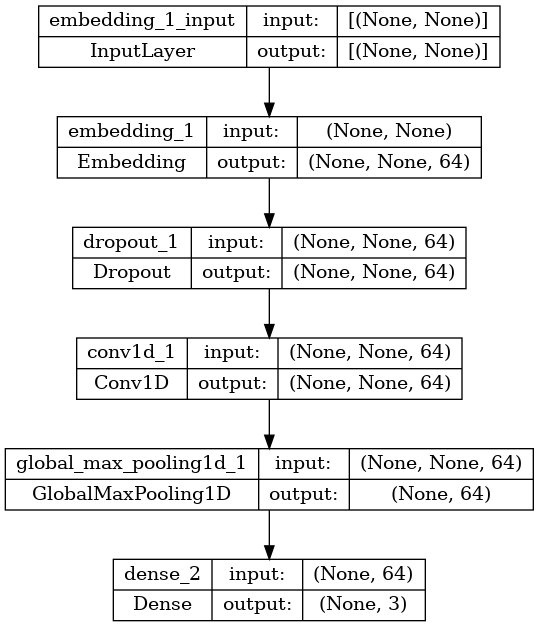

In [76]:
tf.keras.utils.plot_model(model, rankdir='UD', show_shapes=True)

In [77]:
story = model.fit(train_data, validation_data=validation_data, epochs=3)

Epoch 1/3


2024-01-12 01:39:43.684268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:191: Filling up shuffle buffer (this may take a while): 17995 of 50000
2024-01-12 01:39:54.060631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 37s 21ms/step - loss: 0.5811 - accuracy: 0.7336 - val_loss: 0.3856 - val_accuracy: 0.8354
Epoch 2/3


2024-01-12 01:40:10.139686: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3301942109789289461
2024-01-12 01:40:10.139739: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9559340845722509038
2024-01-12 01:40:20.162737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:191: Filling up shuffle buffer (this may take a while): 17172 of 50000


 21/697 [..............................] - ETA: 5s - loss: 0.3739 - accuracy: 0.8512 

2024-01-12 01:40:30.360669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 30s 14ms/step - loss: 0.3594 - accuracy: 0.8528 - val_loss: 0.3429 - val_accuracy: 0.8590
Epoch 3/3


2024-01-12 01:40:50.177684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:191: Filling up shuffle buffer (this may take a while): 17795 of 50000


 16/697 [..............................] - ETA: 7s - loss: 0.2651 - accuracy: 0.8994 

2024-01-12 01:41:02.936912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 33s 14ms/step - loss: 0.2928 - accuracy: 0.8821 - val_loss: 0.3377 - val_accuracy: 0.8594


In [78]:
metrics = model.evaluate(validation_data, return_dict=True)
print("Loss: ", metrics['loss'])
print("Accuracy: {:2.2%}".format(metrics['accuracy']))

79/79 [==============================] - 4s 29ms/step - loss: 0.3377 - accuracy: 0.8594
Loss:  0.3377227187156677
Accuracy: 85.94%


2024-01-12 01:41:18.295195: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3301942109789289461
2024-01-12 01:41:18.295262: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9559340845722509038


Export Model

In [79]:
export_model = tf.keras.Sequential([
    preprocess_text, # Preprocessing layer
    model # Trained model with weights
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [80]:
# Create data of raw strings
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [81]:
# Weird error but everything is works alright I guess
loss, accuracy = export_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 [==============================] - 7s 30ms/step - loss: 1.0709 - accuracy: 0.8594
Loss:  1.0708600282669067
Accuracy: 85.94%


2024-01-12 01:43:52.679545: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9753962951257342027
2024-01-12 01:43:52.679596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16795361730179465591
2024-01-12 01:43:52.679603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4161644499095486614
2024-01-12 01:43:52.679634: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3479041456607445625
2024-01-12 01:43:52.679640: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10171647209355265219
2024-01-12 01:43:52.679644: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10066601594988594690
2024-01-12 01:43:52.679662: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

In [83]:
tf.saved_model.save(export_model, '../saved_models/illiad_export.tf')

INFO:tensorflow:Assets written to: ../saved_models/illiad_export.tf/assets


INFO:tensorflow:Assets written to: ../saved_models/illiad_export.tf/assets


In [84]:
loaded = tf.saved_model.load('../saved_models/illiad_export.tf')
display(export_model(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy())
display(loaded(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy())

array([[-4.133479 , -1.3409759,  1.9229163]], dtype=float32)

2024-01-12 01:54:55.245210: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/StatefulPartitionedCall/sequential_2/StatefulPartitionedCall/my_tokenizer/UnicodeScriptTokenize/RaggedConcat/assert_equal_1/Assert/AssertGuard/branch_executed/_42


array([[-4.133479 , -1.3409759,  1.9229163]], dtype=float32)

Running Inference on new data

In [85]:
inputs = [
    "Join'd to th' Ionians with their flowing robes,",  # Label: 1
    "the allies, and his armour flashed about him so that he seemed to all",  # Label: 2
    "And with loud clangor of his arms he fell.",  # Label: 0
]

predicted_scores = export_model.predict(inputs)
predicted_labels = tf.math.argmax(predicted_scores, axis=1)

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

1/1 [==============================] - 2s 2s/step
Question:  Join'd to th' Ionians with their flowing robes,
Predicted label:  1
Question:  the allies, and his armour flashed about him so that he seemed to all
Predicted label:  2
Question:  And with loud clangor of his arms he fell.
Predicted label:  0


#### IMDB Sentiment Analysis with TensorFlow Datasets

In [86]:
# Training Set
train_ds = tfds.load(
    'imdb_reviews',
    split='train[:80%]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True # Have a 2 tuple (input, label) structure
)

# Validation set
val_ds = tfds.load(
    'imdb_reviews',
    split='train[80%:]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True # Have a 2 tuple (input, label) structure
)

2024-01-12 01:59:06.868180: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "INTERNAL: Couldn't parse JSON response from OAuth server.".


Dl Completed...: 100%|██████████| 1/1 [00:05<00:00,  5.19s/ url]


Dataset imdb_reviews downloaded and prepared to /home/kmirijan/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [87]:
# Let's take a look
for review_batch, label_batch in val_ds.take(1):
    for i in range(5):
        print("Review: ", review_batch[i].numpy())
        print("Label: ", label_batch[i].numpy())

Review:  b"Instead, go to the zoo, buy some peanuts and feed 'em to the monkeys. Monkeys are funny. People with amnesia who don't say much, just sit there with vacant eyes are not all that funny.<br /><br />Black comedy? There isn't a black person in it, and there isn't one funny thing in it either.<br /><br />Walmart buys these things up somehow and puts them on their dollar rack. It's labeled Unrated. I think they took out the topless scene. They may have taken out other stuff too, who knows? All we know is that whatever they took out, isn't there any more.<br /><br />The acting seemed OK to me. There's a lot of unfathomables tho. It's supposed to be a city? It's supposed to be a big lake? If it's so hot in the church people are fanning themselves, why are they all wearing coats?"
Label:  0
Review:  b'Well, was Morgan Freeman any more unusual as God than George Burns? This film sure was better than that bore, "Oh, God". I was totally engrossed and LMAO all the way through. Carrey was

2024-01-12 02:00:02.739146: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [89]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int', # Sequence model
    output_sequence_length=MAX_SEQ_LEN
)

# Remove labels then adapt
train_text = train_ds.map(lambda text,labels: text)
vectorize_layer.adapt(train_text)

In [94]:
def vectorize_text_check(text, label):
    print(text)
    text = tf.expand_dims(text, -1)
    print(text)
    return text, label

train_ds1 = train_ds.map(vectorize_text_check)

Tensor("args_0:0", shape=(None,), dtype=string)
Tensor("ExpandDims:0", shape=(None, 1), dtype=string)


In [95]:
for review_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print("Review: ", review_batch[i])
        print("Label: ", label_batch[i])

for review_batch, label_batch in train_ds1.take(1):
    for i in range(5):
        print("Review: ", review_batch[i])
        print("Label: ", label_batch[i])

Review:  tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label:  tf.Tensor(0, shape=(), dtype=int64)
Review:  tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just

In [96]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

# Confifure data for performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

Tensor("args_0:0", shape=(None,), dtype=string)
Tensor("ExpandDims:0", shape=(None, 1), dtype=string)
Tensor("args_0:0", shape=(None,), dtype=string)
Tensor("ExpandDims:0", shape=(None, 1), dtype=string)


In [97]:
model = create_model(vocab_size=VOCAB_SIZE, num_labels=1)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          20544     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 660609 (2.52 MB)
Trainable params: 660609 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [98]:
model.compile(
    loss = losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
313/313 [==============================] - 25s 76ms/step - loss: 0.6059 - accuracy: 0.6011 - val_loss: 0.4368 - val_accuracy: 0.7830
Epoch 2/3
313/313 [==============================] - 2s 6ms/step - loss: 0.3763 - accuracy: 0.8274 - val_loss: 0.3466 - val_accuracy: 0.8440
Epoch 3/3
313/313 [==============================] - 2s 7ms/step - loss: 0.2892 - accuracy: 0.8755 - val_loss: 0.3206 - val_accuracy: 0.8586


In [99]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 [==============================] - 0s 5ms/step - loss: 0.3206 - accuracy: 0.8586
Loss:  0.32055771350860596
Accuracy: 85.86%


In [100]:
# Export
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid') # Don't really know why you would want to do this. Just from_logits=True right?
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [103]:
# Do some testing

inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say no to watching this movie.",
    "This truly was a movie. Parts of it were good. Parts of it were boring. I can't say it was horrible. Nothing offensive. But ut's not like I was blown away"
]

# 0 bad, 1 good

predicted_scores = export_model.predict(inputs)
predicted_labels = [int(round(x[0])) for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  display(predicted_scores)
  print("Question: ", input)
  print("Predicted label: ", label)
  print()

1/1 [==============================] - 0s 35ms/step


array([[0.9961183 ],
       [0.05432518],
       [0.14102283],
       [0.25633225],
       [0.006433  ]], dtype=float32)

Question:  This is a fantastic movie.
Predicted label:  1



array([[0.9961183 ],
       [0.05432518],
       [0.14102283],
       [0.25633225],
       [0.006433  ]], dtype=float32)

Question:  This is a bad movie.
Predicted label:  0



array([[0.9961183 ],
       [0.05432518],
       [0.14102283],
       [0.25633225],
       [0.006433  ]], dtype=float32)

Question:  This movie was so bad that it was good.
Predicted label:  0



array([[0.9961183 ],
       [0.05432518],
       [0.14102283],
       [0.25633225],
       [0.006433  ]], dtype=float32)

Question:  I will never say no to watching this movie.
Predicted label:  0



array([[0.9961183 ],
       [0.05432518],
       [0.14102283],
       [0.25633225],
       [0.006433  ]], dtype=float32)

Question:  This truly was a movie. Parts of it were good. Parts of it were boring. I can't say it was horrible. Nothing offensive. But ut's not like I was blown away
Predicted label:  0

